## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/


import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [2]:
file_name = "/home/eleonora/data/data_000637.txt"


with open(file_name, "r") as f:
    n = -1 #start from -1 because I have the first row wich does not contain data
    for line in f:
        n += 1

N = int(input("Choose number of rows to read (10k < N <= %d)" %n))

while (N < 1e4 or N > n):
    N = int(input("Choose number of rows to read (10k < N <= %d)" %n))

data = pd.read_csv(file_name, nrows = N)
#data.head(15)
data

Choose number of rows to read (10k < N <= 1310720)100005


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
100000,1,0,63,3869201161,3450,23
100001,1,0,64,3869201161,3452,9
100002,1,0,139,3869201161,3461,0
100003,1,0,124,3869201161,3459,3


2\. Find out the number of BX in a ORBIT (the value 'x').

In [3]:
x = data["BX_COUNTER"].max() + 1 # NB count starts from 0, I have to add 1 to find the value of BX_COUNTER for which I increment the ORBIT
print("x = ", x)

x =  3564


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [4]:
#POINT 3 AND 4 TOGETHER

totdata = pd.read_csv(file_name)

totdata["TIME_ns"] = (totdata["TDC_MEAS"]/30 + totdata["BX_COUNTER"] + totdata["ORBIT_CNT"] * x ) * 25
initialt = totdata["TIME_ns"].min()
finalt = totdata["TIME_ns"].max()
tsec = (finalt - initialt) * math.pow(10, -9)
print("Time needed for data collection (Based on ORBIT_CNT and BX_COUNTER): %f s" %tsec)
totdata["TIME_ns"] = totdata["TIME_ns"] - initialt
totdata

Time needed for data collection (Based on ORBIT_CNT and BX_COUNTER): 0.980416 s


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_ns
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.125000e-01
2,1,0,63,3869200167,2553,28,4.476625e+03
3,1,0,64,3869200167,2558,19,4.594125e+03
4,1,0,64,3869200167,2760,25,9.649188e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [5]:
totdata["HEAD"] = np.random.randint(0, 2, len(totdata))
totdata

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_ns
0,1,0,123,3869200167,2374,26,0.000000e+00
1,0,0,124,3869200167,2374,27,8.125000e-01
2,0,0,63,3869200167,2553,28,4.476625e+03
3,0,0,64,3869200167,2558,19,4.594125e+03
4,0,0,64,3869200167,2760,25,9.649188e+03
...,...,...,...,...,...,...,...
1310715,0,0,62,3869211171,762,14,9.804161e+08
1310716,0,1,4,3869211171,763,11,9.804161e+08
1310717,0,0,64,3869211171,764,0,9.804161e+08
1310718,0,0,139,3869211171,769,0,9.804163e+08


6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [6]:
data = totdata[totdata["HEAD"]==1].copy()
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_ns
0,1,0,123,3869200167,2374,26,0.000000e+00
5,1,0,63,3869200167,2762,4,9.681625e+03
9,1,0,60,3869200167,2788,7,1.033412e+04
12,1,1,6,3869200167,2792,18,1.044331e+04
14,1,0,56,3869200167,2789,3,1.035581e+04
...,...,...,...,...,...,...,...
1310702,1,0,27,3869211171,18,17,9.803975e+08
1310706,1,0,28,3869211171,44,29,9.803982e+08
1310708,1,0,124,3869211171,199,9,9.804020e+08
1310710,1,1,36,3869211171,427,13,9.804077e+08


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

<Figure size 432x288 with 0 Axes>

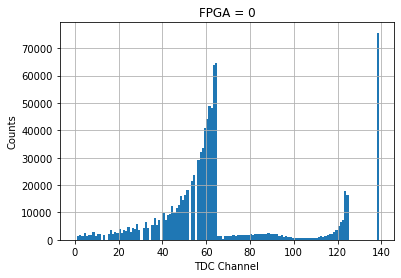

<Figure size 432x288 with 0 Axes>

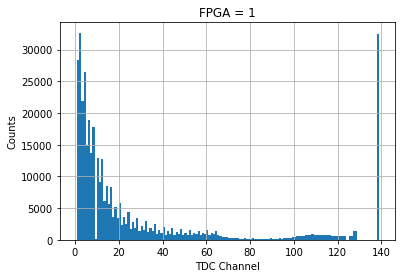

In [7]:
def plttdc(dat, n):
    mtdc = dat["TDC_CHANNEL"].min()
    Mtdc = dat["TDC_CHANNEL"].max()
    plt.figure()
    dat[dat["FPGA"]== n].hist("TDC_CHANNEL", bins = range(mtdc-1, Mtdc+1))
    plt.title("FPGA = " + str(n))
    plt.ylabel("Counts")
    plt.xlabel("TDC Channel")
    plt.show()

plttdc(totdata, 0)
plttdc(totdata, 1)

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [8]:
totdata["COUNT"] = np.ones(len(totdata))
tdc = totdata.groupby("TDC_CHANNEL").sum() #group by tdc_channel and sum number along columns items having same channel
tdc = tdc.sort_values(by = "COUNT", ascending = False)
print("Most noisy channels: ", list(tdc.index[0:3]))

Most noisy channels:  [139, 64, 63]


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [9]:
un_orb = totdata["ORBIT_CNT"].nunique()
un_orb_139 = totdata[ totdata["TDC_CHANNEL"] == 139 ]["ORBIT_CNT"].nunique()

print("number of unique orbits: ", un_orb)
print("number of unique orbits with at least one measurement from TDC_CHANNEL=139 : ", un_orb_139)

number of unique orbits:  11001
number of unique orbits with at least one measurement from TDC_CHANNEL=139 :  10976
